In [1]:
from datetime import datetime
from glob import glob
import pandas as pd
import numpy as np

In [2]:
from matplotlib import patches
import cv2

In [3]:
def PolyArea(x,y):
    return 0.5*np.abs(np.dot(x,np.roll(y,1))-np.dot(y,np.roll(x,1)))

In [4]:
df   = pd.DataFrame([{'fname': f} for f in glob('/data/2/Sentinel2-crops/T32TPQ/*/20*')])
mask_pano = pd.DataFrame([{'fname': f} for f in glob('/data/2/Sentinel2-crops/T32TPQ/*/crops_panoptic.npy')])
mask_sema = pd.DataFrame([{'fname': f} for f in glob('/data/2/Sentinel2-crops/T32TPQ/*/crops_semantic.npy')])

In [5]:
mask_pano['label'] = mask_pano.fname.apply(lambda x: x.split('/')[5])
mask_sema['label'] = mask_sema.fname.apply(lambda x: x.split('/')[5])
df['label'] = df.fname.apply(lambda x: x.split('/')[5])
df['date']  = df.fname.apply(lambda x: datetime.strptime(x.split('/')[-1].split('.')[0], '%Y%m%d'))

In [6]:
df = df.groupby('label').apply(lambda x: x.sort_values(by='date', ascending=False).iloc[0])

In [7]:
df = pd.concat([df, 
                mask_pano.set_index('label').fname.rename('panoptic'),
                mask_sema.set_index('label').fname.rename('semantic')], 
               axis=1, join='inner')
df = df.reset_index(drop=True) 

In [8]:
df.head()

,fname,label,date,panoptic,semantic
0,/data/2/Sentinel2-crops/T32TPQ/n44168e11547/20...,n44168e11547,2022-08-16,/data/2/Sentinel2-crops/T32TPQ/n44168e11547/cr...,/data/2/Sentinel2-crops/T32TPQ/n44168e11547/cr...
1,/data/2/Sentinel2-crops/T32TPQ/n44168e11563/20...,n44168e11563,2022-08-16,/data/2/Sentinel2-crops/T32TPQ/n44168e11563/cr...,/data/2/Sentinel2-crops/T32TPQ/n44168e11563/cr...
2,/data/2/Sentinel2-crops/T32TPQ/n44168e11579/20...,n44168e11579,2022-08-16,/data/2/Sentinel2-crops/T32TPQ/n44168e11579/cr...,/data/2/Sentinel2-crops/T32TPQ/n44168e11579/cr...
3,/data/2/Sentinel2-crops/T32TPQ/n44169e11515/20...,n44169e11515,2022-08-16,/data/2/Sentinel2-crops/T32TPQ/n44169e11515/cr...,/data/2/Sentinel2-crops/T32TPQ/n44169e11515/cr...
4,/data/2/Sentinel2-crops/T32TPQ/n44169e11531/20...,n44169e11531,2022-08-16,/data/2/Sentinel2-crops/T32TPQ/n44169e11531/cr...,/data/2/Sentinel2-crops/T32TPQ/n44169e11531/cr...


In [32]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import matplotlib 

# Colormap (same as in the paper)

cm = matplotlib.cm.get_cmap('tab20')
def_colors = cm.colors
cus_colors = ['k'] + [def_colors[i] for i in range(1,19)]+['w']
cmap = ListedColormap(colors = cus_colors, name='agri',N=20)

label_names =   [
                    "Background","Meadow","Soft winter wheat",
                    "Corn","Winter barley","Winter rapeseed",
                    "Spring barley","Sunflower","Grapevine",
                    "Beet","Winter triticale","Winter durum wheat",
                    "Fruits,  vegetables, flowers","Potatoes",
                    "Leguminous fodder","Soybeans","Orchard",
                    "Mixed cereal","Sorghum","Void label"
                ]

def get_rgb(im,b=0,t_show=6):
    """Gets an observation from a time series and normalises it for visualisation."""
    mx = im.max(axis=(1,2))
    mi = im.min(axis=(1,2))   
    im = (im - mi[:,None,None])/(mx - mi)[:,None,None]
    im = im.swapaxes(0,2).swapaxes(0,1)
    im = np.clip(im, a_max=1, a_min=0)
    return im

In [35]:
sample = df.sample(1)

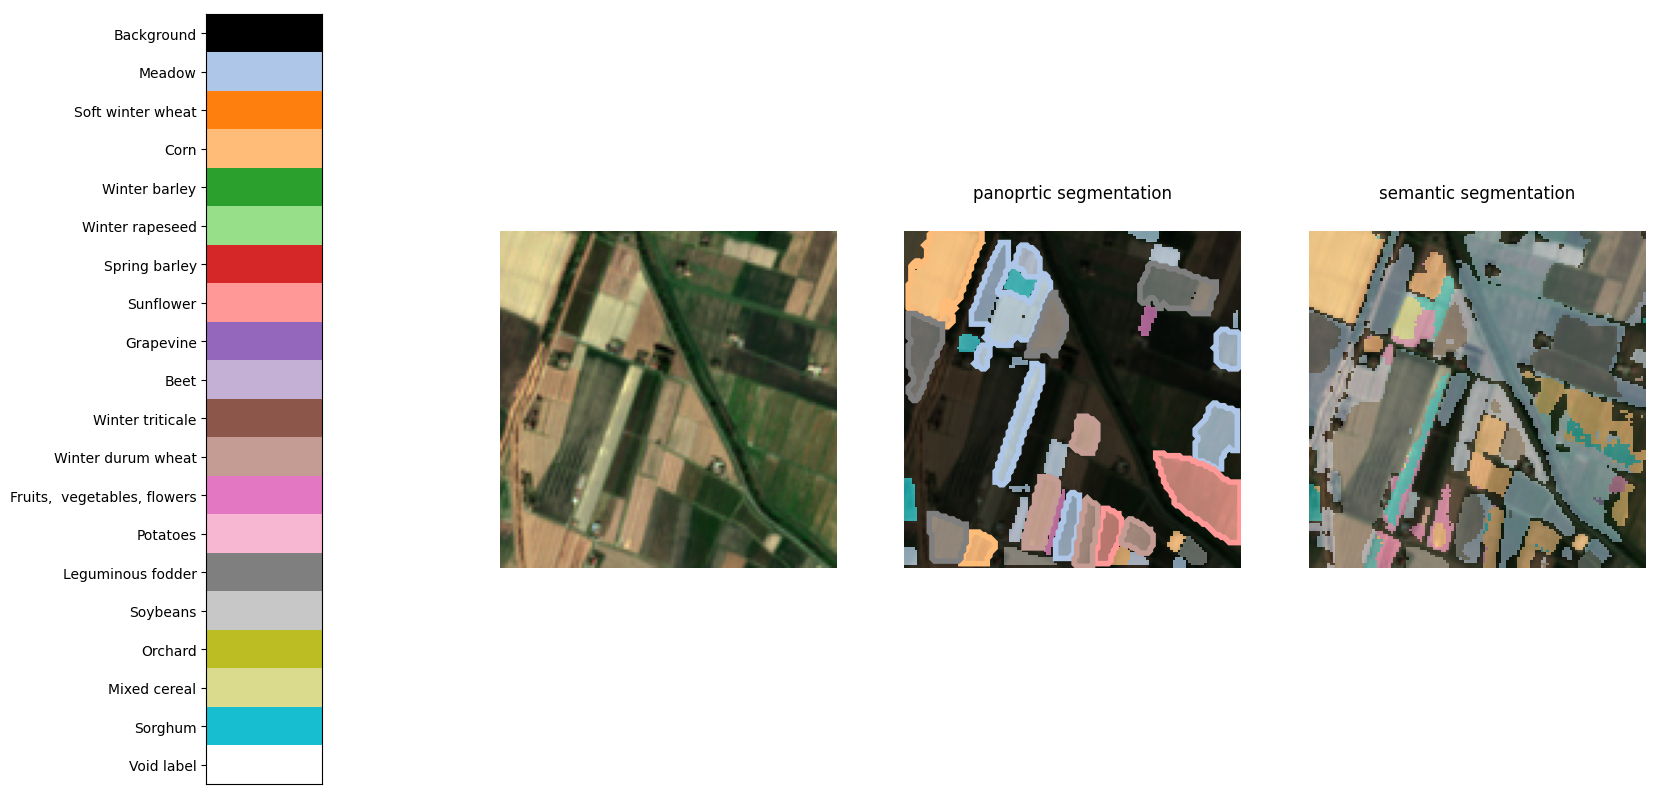

In [44]:
fig, ax = plt.subplots(1, 4, figsize=(20, 10))

ax[0].matshow(np.stack([np.arange(0, 20) for _ in range(3)], axis=1), cmap = cmap)
ax[0].set_yticks(ticks = range(20), labels=label_names)
ax[0].set_xticks(ticks=[])

image = get_rgb(np.load(sample.iloc[0].fname)[0:3])[:, :, [2, 1, 0]]
ax[1].imshow(image, interpolation=None)


mask_pano = np.load(sample.iloc[0].panoptic)[0]
mask_sema = np.load(sample.iloc[0].semantic)[0]

labels = np.unique(mask_pano).astype(int)
labels = labels[(labels > 0) & (labels < 19)]

ax[2].imshow(image, interpolation=None)
ax[2].matshow(mask_pano,cmap=cmap,vmin=0,vmax=19, alpha=0.7)

for i, l in enumerate(labels):
    c,h= cv2.findContours((mask_pano==l).astype(int), 
                          cv2.RETR_FLOODFILL, 
                          cv2.CHAIN_APPROX_SIMPLE)

    color = cmap.colors[l]

    for co in c[1::2]:
        if PolyArea(co[:,0,0], co[:,0,1]) > 100:
            # poly = patches.Polygon(co[:,0,:], fill=True, alpha=0.3, linewidth=0, color=color)
            # ax[1].add_patch(poly)
            poly = patches.Polygon(co[:,0,:], fill=False, alpha=1, linewidth=4, color=color)
            ax[2].add_patch(poly)
            

labels = np.unique(mask_sema).astype(int)
labels = labels[(labels > 0) & (labels < 19)]

ax[3].imshow(image, interpolation=None)
ax[3].matshow(mask_sema,cmap=cmap,vmin=0,vmax=19, alpha=0.5)
        
ax[2].set_title('panoprtic segmentation')
ax[3].set_title('semantic segmentation')

ax[1].axis('off')
ax[2].axis('off')
ax[3].axis('off')
    
plt.show()